# Application of di-PLS for domain adaptation
## Dr. Ramin Nikzad-Langerodi
### Bottleneck Analytics GmbH
info@bottleneck-analytics.com

___
First we load some modules that we will be using including the di-PLS class.

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
from diPLSlib.models import DIPLS as dipls
from diPLSlib import functions as fct

### Data Set

Let's create some simulated *Source* and *Target domain* data sets with N=50 and p=100 samples and variables, respectively. 

In [2]:
n = 50  # Number of samples
p = 100 # Number of variables

To this end, we define 3 Gaussians where the first will correspond to the (*analyte*) signal that we will try to model and the other two will correspond to disturbing signals (*interferents*). 

The Source domain data set will contain only analyte information and contributions from **one** of the two interferents.

In [3]:
np.random.seed(10)

# Source domain (analyte + 1 interferent)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte signal
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1 signal
S = np.vstack([S1,S2])

# Analyte and interferent concentrations
Cs = 10*np.random.rand(n,2)

# Spectra
Xs = Cs@S

In the Target domain we will have contributions from the analyte and **both** interferents.

In [4]:
# Target domain (Analyte + 2 Interferents)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte signal
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1 signal
S3 = fct.gengaus(p, 30, 10, 10, 0) # Interferent 2 signal
S = np.vstack([S1,S2,S3])

# Analyte and interferent concentrations
Ct = 10*np.random.rand(n,3)

# Spectra
Xt = Ct@S

Let's plot the pure signals of analyte and interferents as well as the simulated data sets.

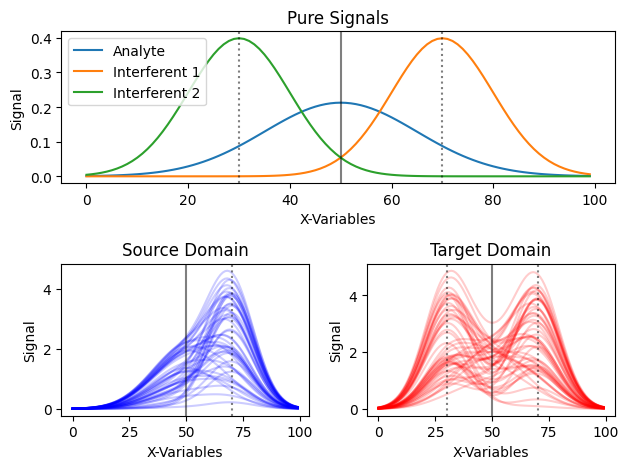

In [5]:
# Plot pure signals
plt.figure()

plt.subplot(211)
plt.plot(S1)
plt.plot(S2)
plt.plot(S3)
plt.legend(['Analyte','Interferent 1','Interferent 2'])
plt.title('Pure Signals')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)

# Source domain
plt.subplot(223)
plt.plot(Xs.T, 'b', alpha=0.2)
plt.title('Source Domain')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)

# Target domain
plt.subplot(224)
plt.plot(Xt.T, 'r', alpha=0.2)
plt.title('Target Domain')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)
plt.tight_layout()

### Partial Least Squares Regression (PLS)
We will now try to model the analyte concentration in the Source domain given the simulated spectra and apply the model in the Target domain using standard PLS.

Text(0.5, 1.0, 'Standard PLS')

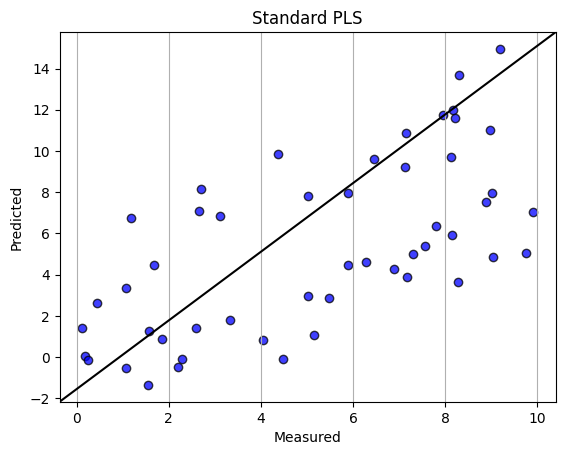

In [6]:
# Source domain PLS Model (2 LVs)
y = np.expand_dims(Cs[:, 0],1)
m = dipls(Xs, y, Xs, Xt, 2)
l = [0] # No regularization
m.fit(l)
b_source = m.b

# Predict analyte in the target domain
yhat_pls, err = m.predict(Xt)

# Plot measured vs predicted analyte concentrations
plt.scatter(Ct[:, 0], yhat_pls, color='b', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('Standard PLS')

As expected, the predictions of the Source model are not very accurate when applied in the Target domain because the latter contains contributions from an additional interferent.

### Domain-invariant Partial Least Squares (di-PLS)
We will now include the Target domain data (without the corresponding analyte concentrations) and add some domain regularization to account for the additional interferent in the target domain.

Text(0.5, 1.0, 'di-PLS')

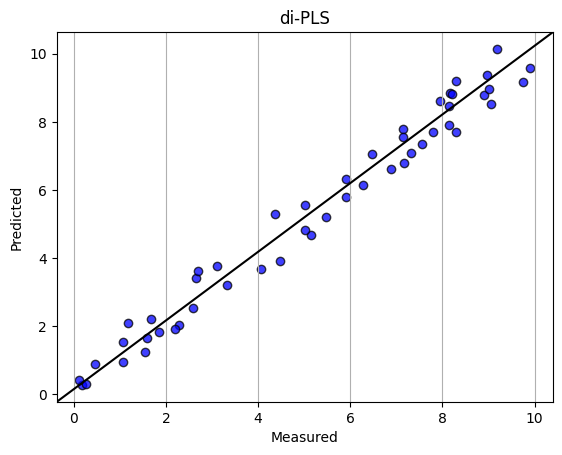

In [7]:
# di-PLS model (2 LVs)
y = np.expand_dims(Cs[:, 0],1)
m = dipls(Xs, y, Xs, Xt, 2)
l = [100000] #  Regularization
m.fit(l)
b_inv = m.b

# Predict analyte in the Target domain
yhat_dipls, err = m.predict(Xt)

# Plot measured vs predicted analyte concentrations
plt.scatter(Ct[:, 0], yhat_dipls, color='b', edgecolor='k',alpha=0.75)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k', transform=ax.transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.grid(axis='x')
plt.title('di-PLS')

The model now predicts the analyte concentrations in the Target domain with high accuracy! Note that we have only included X but no Y data from the Target domain (along with the X and Y data from the Source domain) to find a good model for the Target (and the Source!) domain. This is sometimes referred to as *unsupervised domain adaptation* in literature.

Let's try to understand how di-PLS improves the predictions in the Target domain. To this end, we will take a look at the projections of Source and Target domain data onto the latent variable (LV) spaces spanned by the PLS and di-PLS models.

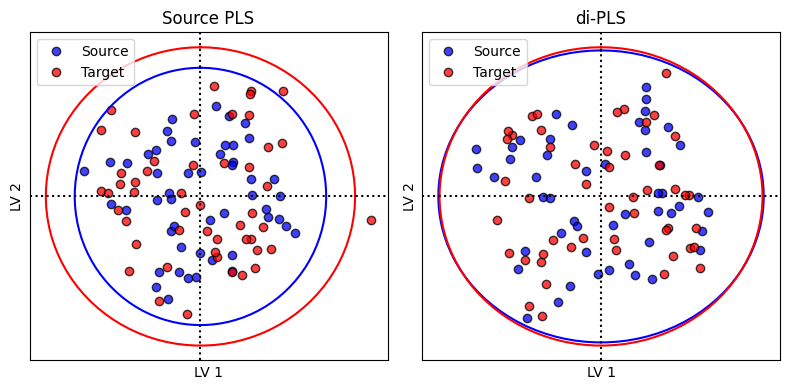

In [8]:
plt.figure(figsize=(8,4))

# PLS projections (scores)
plt.subplot(1,2,1)
m.fit([0])
plt.plot(m.Ts[:, 0], m.Ts[:, 1], 'ob', mec='k', 
alpha=0.75)
plt.plot(m.Tt[:, 0], m.Tt[:, 1], 'or', mec='k', alpha=0.75)
plt.legend(['Source', 'Target'], loc=2)
el_source = fct.hellipse(m.Ts)
el_target = fct.hellipse(m.Tt)
plt.plot(el_source[0,:],el_source[1,:],'b')
plt.plot(el_target[0,:],el_target[1,:],'r')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.axhline(y=0,color='k',linestyle=':')
plt.axvline(x=0,color='k',linestyle=':')
plt.title('Source PLS')
plt.xlabel('LV 1')
plt.ylabel('LV 2')

# di-PLS scores
plt.subplot(1,2,2)
m.fit(l)
plt.plot(m.Ts[:, 0], m.Ts[:, 1], 'ob', mec='k', 
alpha=0.75)
plt.plot(m.Tt[:, 0], m.Tt[:, 1], 'or', mec='k', alpha=0.75)
plt.legend(['Source', 'Target'], loc=2)
el_source = fct.hellipse(m.Ts)
el_target = fct.hellipse(m.Tt)
plt.plot(el_source[0,:],el_source[1,:],'b')
plt.plot(el_target[0,:],el_target[1,:],'r')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
plt.axhline(y=0,color='k',linestyle=':')
plt.axvline(x=0,color='k',linestyle=':')
plt.title('di-PLS')
plt.xlabel('LV 1')
plt.ylabel('LV 2')
plt.tight_layout()

As can be seen from the two plots, the distributions of Source and Target domain scores (i.e. the projections on the LV spaces) are much better aligned in the di-PLS model. Modelling the analyte in the Source domain using LVs for which the data from the Source and Target domains look *as if they were sampled from the same underlying distribution* improves generalization across the domains. This follows directly from the *theory of learning from different domains* (Ben-David et al. Mach. Learn. 2010).

Let's now look at the regression coefficients of the PLS and di-PLS models.

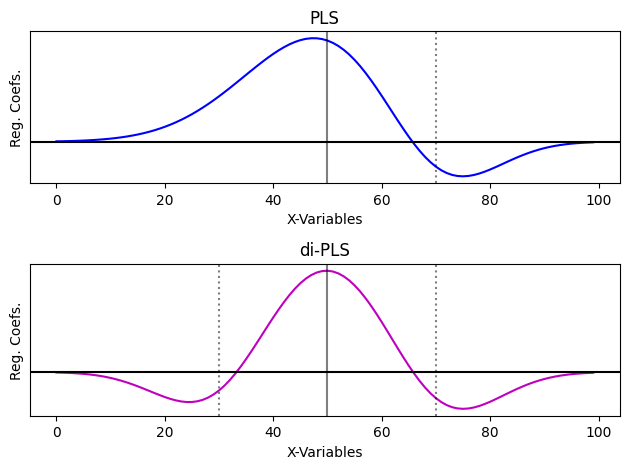

In [9]:
# PLS regression coefficients
plt.subplot(2,1,1)
plt.plot(b_source, 'b')
plt.axhline(y=0, linestyle='-',color='k')
plt.ylabel('Reg. Coefs.')
plt.xlabel('X-Variables')
plt.tick_params(labelleft=False, left=False)
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.title('PLS')

# di-PLS regression coefficients
plt.subplot(2,1,2)
plt.plot(b_inv, 'm')
plt.axhline(y=0, linestyle='-',color='k')
plt.ylabel('Reg. Coefs.')
plt.xlabel('X-Variables')
plt.tick_params(labelleft=False, left=False)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.title('di-PLS')
plt.tight_layout()

It can be seen that the PLS model "compensates" for the first interferent whose signal has a maximum at X=70 (dashed line). In addition, the di-PLS model compensates for the second interferent (maximum signal at X=30), which explains why the latter generalizes better to the Target domain. 